Let's represent oscillation-based data into audio data! An obvious example of oscillation in nature are ocean waves! I'll be using the data from [here](https://www.kaggle.com/jolasa/waves-measuring-buoys-data-mooloolaba).

In [166]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sklearn
%matplotlib inline

In [167]:
data = pd.read_csv('data/buoy.csv', low_memory=False)
data.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45


In [168]:

x = data.iloc[1:,1]

def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

## There's some nasty errors/outliers, so let's get rid of them
x = reject_outliers(x, 20)

## Shift downwards to center on x axis
x = x - np.mean(x)

As you can see, the data is waveform-esque, meaning that we can represent it as audio fairly simply.

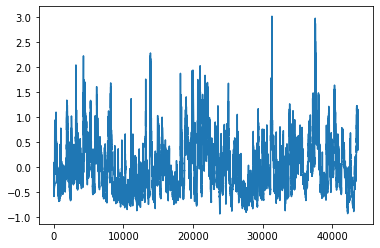

In [169]:
plt.plot(x)

In [170]:
import math

def normalize(x, dB):

    ampMax = np.amax(abs(x))
    ampTarget = math.pow(10, dB / 20)
    normFactor = ampTarget / ampMax

    # Return the normalized signal.
    return x * normFactor

In [171]:
xn = normalize(x, -3)

In [172]:
## With a sample rate of 44100 hz, the result lasts <1 second. So let's use a sample rate of 22050 instead.
sr = int(44100/2) # sample rate
ipd.Audio(xn, rate=sr)

Sounds very clothlike. Let's export it to file so we can play around with it further.

In [173]:
import soundfile as sf
sf.write('./output/buoy.wav', xn, int(sr), 'PCM_24')
x, sr = librosa.load('./output/buoy.wav')

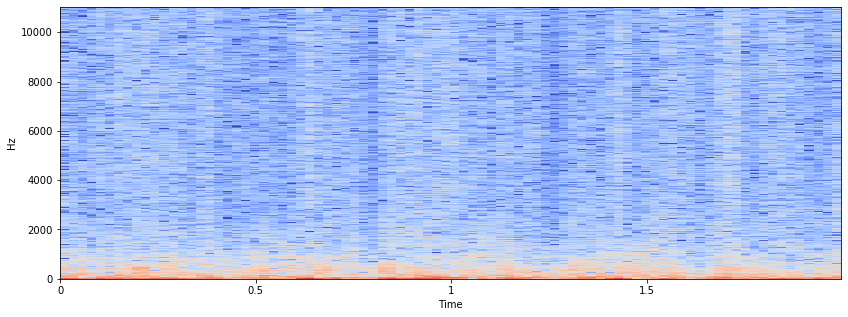

In [174]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

We can get the spectral centroid (an indicator of sound brightness) like so:

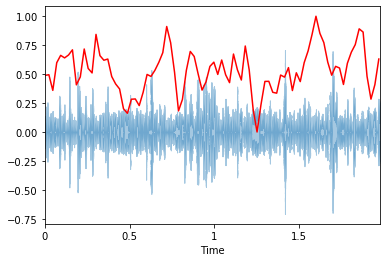

In [183]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0), color='r')

Or the zero crossing rate. Here we'll see that the beginning has a higher ZSC, which probably indicates a higher amount of noise.

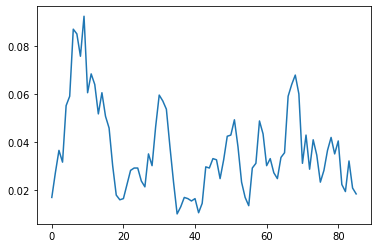

In [185]:
zcrs = librosa.feature.zero_crossing_rate(x)
plt.plot(zcrs[0])

But we probably want something more concrete, so let's get the note breakdown using a Constant-Q transform...

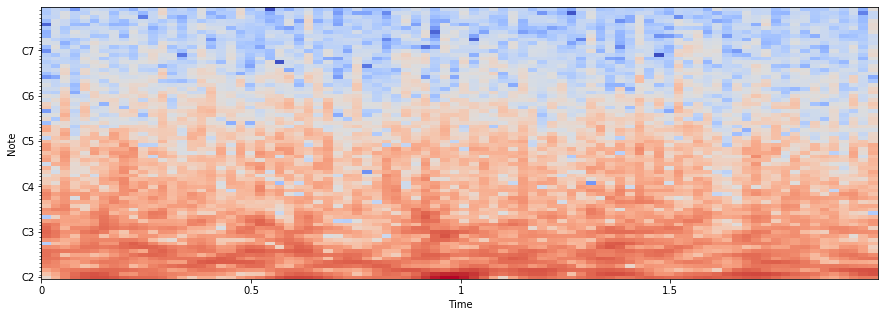

In [194]:
fmin = librosa.midi_to_hz(36)
hop_length = 512
C = librosa.cqt(x, sr=sr, fmin=fmin, n_bins=72, hop_length=hop_length)
logC = librosa.amplitude_to_db(np.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')


Well, I don't know what else I expected!

So far the audification hasn't been too pleasing to listen to. Judging from the feature extractions, we'll need to reduce the noisiness. We can likely mitigate noisiness by reducing the playback speed